# Binary Classification on the MNIST dataset

As an example to showcase the use of the `qiboml` Pytorch interface, we demonstrate in the following how to run a simple binary classification problem on the MNIST data. We are going to combine a classical image encoder with a quantum classification head to learn to ditinguish zeros and ones.

Before that, though, let's install the required packages.

## Installing Requirements

In [1]:
# qiboml, provides the means to build the quantum model
!pip install git+https://github.com/qiboteam/qiboml

# torch, handles the creation of all the classical layers
# and provides the optimizer
!pip install torch

# some additional requirements to run this notebook
# torchvision to gather the MNIST dataset
# torchmetrics to evaluate the performance
# matplotlib to do some plotting
!pip install torchvision torchmetrics matplotlib

  Cloning https://github.com/qiboteam/qiboml to /tmp/pip-req-build-48ms9g2r
  Running command git clone --filter=blob:none --quiet https://github.com/qiboteam/qiboml /tmp/pip-req-build-48ms9g2r
  Resolved https://github.com/qiboteam/qiboml to commit 00646440eb4f781a4e24bf948ecd88b2036721f7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/qiboteam/qibo to /tmp/pip-install-524ps7jg/qibo_86a1ff951b7f492ea50bb561234ba265
  Running command git clone --filter=blob:none --quiet https://github.com/qiboteam/qibo /tmp/pip-install-524ps7jg/qibo_86a1ff951b7f492ea50bb561234ba265
  Resolved https://github.com/qiboteam/qibo to commit f4cf9afdcbe50e43661428d9072d5fdcd9c71175
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for qiboml: filename=qiboml-0.0.1-py3-none-any.whl size=23004 sha2

## Dataset Preparation

Now, let's start by downloading the MNIST dataset. Each element of the dataset is a `28x28` black and white image representing a hand written digit from `0` to `9`. However, since we are interested in just the zeros and ones for our simplified binary classification problem, we extract from the complete dataset just the element that are labeled as either `0` or `1`. 

Since the problem is relatively simple, we will not need the whole dataset, but, rather, about 100 train samples should be enough to obtain a reasonable accuracy. Analogously, we also take other 100 samples for testing.

In [2]:
from torchvision.datasets import MNIST

# get the MNIST dataset
dataset = MNIST("./", download=True)
# each element is an image of shape 28x28
print(f"First element of the dataset:\nlabel: {dataset[0][1]}\nshape: {dataset.data[0].shape}\nimage:\n")
display(dataset[0][0])

# we keep only the zeros and ones for binary classification
zeros_and_ones = [i for i, d in enumerate(dataset) if d[1] in (0,1)]
# for this small example 100 data for training should be enough
# we also extract 100 other data for testing
# in practice we take the first 200 zeros and ones found in the dataset
train_data, test_data = dataset.data[zeros_and_ones][:200].double().view(2, 100, 1, 28, 28)
train_targets, test_targets = dataset.targets[zeros_and_ones][:200].double().view(2, 100, 1)
# flatten the targets
train_targets, test_targets = train_targets.view(-1,), test_targets.view(-1,)
train_images = [dataset[i][0] for i in zeros_and_ones][:100]
test_images = [dataset[i][0] for i in zeros_and_ones][100:200]

print(f"\nFirst element of our binary classification task:\nlabel: {int(train_targets[0])}\nimage:\n")
display(train_images[0])

First element of the dataset:
label: 5
shape: torch.Size([28, 28])
image:




First element of our binary classification task:
label: 0
image:



## Construct the Image Encoder

Now that we have prepared all the data we need, we can move to creating the image encoder first. This is going to take care of the initial encoding of the images, mapping the original `28x28` matrix into `n` output features. As it will become clearer in the following, the dimension of the extracted features, `n`, has to be consistent with the quantum classification head. For instance, as in this example we are going to use a simple phase encoding to encode the features in rotation angles on the different qubits (one rotation for each qubit), we will have that `n` equals the number of qubits of the variational circuit.

The image encoder is a purely classical layer, composed by a convolution, a pooling and a bunch of linear layers. Everything is implemented trhough the native `pytorch` API.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# we can define a classical image encoder
# composed of a combination of convolutional, pooling and linear layers

# number of extracted output features
n_out_features = 2

class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 13 * 13, 32)
        self.fc3 = nn.Linear(32, n_out_features)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x) 
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x

# we cast the layer to double precision, as this is the 
# default dtype used in qiboml, and more in general 
# for quantum simulation
# this could could also be achieved by setting the torch 
# default dtype at the beginning with `torch.set_default_dtype(torch.float64)`
img_encoder = ImageEncoder().double()


## Define the Quantum model

On top of the classical image encoder we are going to build a quantum classification layer. This can be done by using the `pytorch` interface provided by `qiboml`, namely the `qiboml.models.pytorch.QuantumModel`. In particular, to build a quantum model we need to specify three different components:

- the **encoding**: how the classical data is encoded into the quantum circuit
- the **circuit**: the actual variational circuit that we train
- the **decoding**: how the quantum information is decoded to recover a classical output

`qiboml` provides some predefined standard layers for those in the three modules `qiboml.models.encoding`, `qiboml.models.decoding` and `qiboml.models.ansatze`. For example, we could use:

- **PhaseEncoding**: encodes the input features in `RY` rotations, one rotation on a different qubit for each feature
- **Expectation**: decodes the quantum information by taking the expectation value of an observable on the final state after circuit execution

and combine them with a custom variational circuit containing some parametrized rotations and entangling gates that we manually define.

The `QuantumModel` can then be constructed by passing the three components `QuantumModel(encoding, circuit, decoding)`.

Note that, as normally in `qibo`, you can set a global backend for the circuit execution. The backend choice mainly affects the decoding and autodifferentiation process, as, depending on the backend, different settings might be or not be available and differentiation is performed in a different way. For the time being, in this simple example, we are just going to use the `pytorch` backend that allows for native pytorch differentiation with the pytorch interface.

In [7]:
import numpy as np
from qibo import set_backend, Circuit, gates
from qibo.symbols import Z
from qibo.hamiltonians import SymbolicHamiltonian

from qiboml.interfaces.pytorch import QuantumModel
from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation

# then we build the quantum model, that will
# act as a classification layer on top of the
# classical image encoder

# let's set the qibo global backend with the one we like,
# e.g. pytorch 
set_backend(backend="qiboml", platform="pytorch")

# we prepare a quantum encoder to encode the 
# classical data in a quantum circuit
# the number of qubits has to be equal to the number of
# features extracted on the preceding layer, i.e. the
# outputs of the image encoder
nqubits = n_out_features
encoding = PhaseEncoding(nqubits=nqubits)

# we construct a trainable parametrized circuit
# that is the core of our quantum model
circuit = Circuit(nqubits)
for _ in range(5):
    for q in range(nqubits):
        circuit.add(gates.RY(q, theta=np.random.randn() * np.pi))
        circuit.add(gates.RZ(q, theta=np.random.randn() * np.pi))
    circuit.add(gates.CNOT(0,1))
print("Trainable Circuit:")
circuit.draw()

# and finally we need a decoder to decode the quantum
# information and extract the classical predictions,
# for instance the expectation value calculation

# for this we need to define the observable we wish to
# measure
observable = SymbolicHamiltonian(Z(0), nqubits=nqubits)
# and then construct the expectation decoder
decoding = Expectation(nqubits=nqubits, observable=observable, nshots=None)

# we can then build the complete quantum model
q_model = QuantumModel(
    encoding,
    circuit,
    decoding
)

[Qibo 0.2.16|INFO|2025-01-20 11:24:36]: Using qiboml (pytorch) backend on cpu


Trainable Circuit:
0: ─RY─RZ─o─RY─RZ─o─RY─RZ─o─RY─RZ─o─RY─RZ─o─
1: ─RY─RZ─X─RY─RZ─X─RY─RZ─X─RY─RZ─X─RY─RZ─X─


## Set up a custom activation for the Quantum model

The final ingredient that we miss is an activation for the quantum layer. This is not stricly mandatory, in the sense that the pipeline would still work regardless, but, depending on the situation, it is usually a good idea to control what kind of data we are encoding in our circuit. 

For example, in this case we are using a phase encoding, meaning that we encode the data directly in rotation angles on the Bloch sphere. However, the features extracted by the classical image encoder can in principle take values in $ \mathbb{R}^n $, while the rotations have a periodicity of $ 2\pi $. Thus, taking for instance a rotation of $237.43$ is not very meaningful on its own, but more importantly, a small difference in such a large angle might still lead to a very different encoded quantum information, leading to a great asymmetry or incosistency between the classical and quantum layers that could make training the model very complicated. Note that the same is true in the opposite direction: a very large value but close to a multiple of $2\pi$ (for instance $200 \pi + \epsilon$), would result in the exact same rotation as the small $\epsilon$ signal.

To put it into numbers, consider fo example the two features $237.43$ and $234.29$, while being very similar from the perspective of the image encoder, they account in practice for roughly a $ \pi $ rotation ($ 237.43 - 234.29 = 3.14 $) for the quantum encoder. That's half of a full rotation on the Bloch sphere!

Viceversa, two extremely different data for the classical image encoder, such as $3140$ ($\sim 3000\pi$) and $3.14$ ($\sim \pi$) would result in the exact same encoded quantum information.

For this reason, in this case, we could define a custom activation that takes the outputs of the image encoder and maps them in the $(-\pi, \pi)$ interval through some nonlinear activation, e.g. the hyperbolic tangent. This again, is purely classical and thus we only rely on the pytorch API for the implementation.

In [8]:
# Since we are using an angular encoding, it is better to
# make sure that the output of the img_encoder are meaningful
# angles. To do so we can define a custom torch activation
# that rescales everything in the interval (-pi, pi)

class PiTanh(nn.Module):

    def forward(self, x):
        # we first rescale x to avoid the risk
        # of saturating the tanh too often and, thus,
        # producing always the same angle
        x = x / x.max()
        # then we just apply the tanh and rescale by pi
        return np.pi * F.tanh(x)

activation = PiTanh().double()

## Put everything together

We can finally build the complete model by stacking the different layers on top of each other through the pytorch `Sequential` model.

In [9]:
# Finally, the complete hybrid classical-quantum pipeline can
# be built by stacking the different components in a 
# torch.nn.Sequential as usual
model = nn.Sequential(
    img_encoder,
    activation,
    q_model,
)

print(model)

Sequential(
  (0): ImageEncoder(
    (conv1): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=507, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
  )
  (1): PiTanh()
  (2): QuantumModel(encoding=PhaseEncoding(nqubits=2, qubits=[0, 1], _circuit=<qibo.models.circuit.Circuit object at 0x7fedd8dd1840>), circuit=<qibo.models.circuit.Circuit object at 0x7fedd8dd29b0>, decoding=Expectation(nqubits=2, qubits=[0, 1], nshots=None, backend=qiboml (pytorch), _circuit=<qibo.models.circuit.Circuit object at 0x7fedd8393160>, observable=<qibo.hamiltonians.hamiltonians.SymbolicHamiltonian object at 0x7fedd87226e0>), differentiation=None)
)


## Baseline performance evaluation

We are ready to run the model now!

Let's start by checking how the model performs before any training happened, i.e. with just the random initialization.
To do that we can use a standard classification metric, the [F1 score](https://en.wikipedia.org/wiki/F-score), that combines precision and recall in a single score.

As the problem is a simple binary classification task, even random guessing would result in roughly 50% accuracy, thus nonzero performance shouldn't surprise you and may vary depending on the random initialization.

In [10]:
# to evaluate the performance of the model we can use the
# standard binary F1 score
from torcheval.metrics.functional import binary_f1_score

# let's check how the model does before training on the test set
with torch.no_grad():
    predictions = torch.as_tensor([F.sigmoid(model(x)) for x in test_data])
    print(f"Untrained F1 score: {binary_f1_score(predictions, test_targets)}\n")

# we can also manually display and check some predictions and input images 
for prediction, image in zip(predictions[:5], test_images[:5]):
    print(f"Prediction: {prediction.round()}\nImage:")
    display(image)


Untrained F1 score: 0.5849056603773585

Prediction: 0.0
Image:


Prediction: 0.0
Image:


Prediction: 0.0
Image:


Prediction: 0.0
Image:


Prediction: 1.0
Image:


## Train the model 

Now we can train the model on the train set as we would do normally for any other pytorch model. We use the `Adam` optimizer and train for 5 epochs, updating the parameters after each train sample. Thus we calculate $5 \cdot 100$ losses in total and perform $500$ parameters update as well. 

To double check that the training is working we can plot the evolution of the loss over training. As each point of the plot consists the loss for a single sample of the train set, large variations are to be expected, but the overall trend should clearly be descending.

Final Loss: 0.33480558732640076


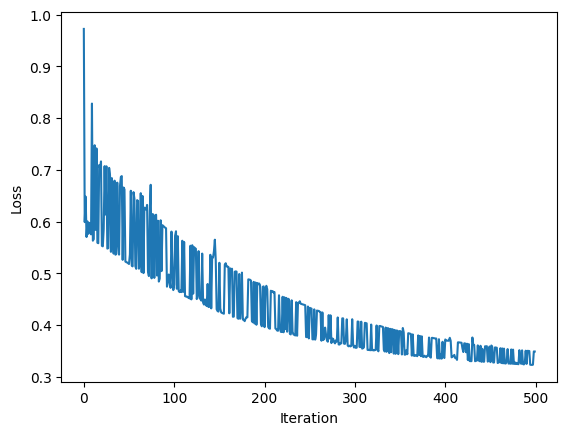

In [11]:
import matplotlib.pyplot as plt
from torch.optim import Adam

# now we can train the model as we would do
# with any other pytorch model

# let's use the torch.optim.Adam optimizer
optimizer = Adam(model.parameters())
# we are going to train for 5 epochs
losses = []
for _ in range(5):
    # reshuffle the data before each epoch
    permutation = torch.randperm(len(train_data))
    for x, y in zip(train_data[permutation], train_targets[permutation]):
        optimizer.zero_grad()
        # get the predictions
        out = model(x)
        # calculate the loss, we can take the
        # standard binary cross entropy
        loss = F.binary_cross_entropy_with_logits(out.view(1,), y.view(1,))
        # backpropagate
        loss.backward()
        # update the parameters
        optimizer.step()
        losses.append(loss.item())

# we can plot the training loss over the epochs
plt.plot(range(len(losses)), losses)
plt.ylabel("Loss")
plt.xlabel("Iteration")
# for reference we calculate the average loss obtained for
# the last 20 predictions after training
print(f"Final Loss: {sum(losses[-20:])/20}")

## Evaluate the trained model

After training we can again evaluate the model on the test data through the F1 score 

In [12]:
# Finally, let's double check that the F1 score has improved
with torch.no_grad():
    predictions = torch.as_tensor([F.sigmoid(model(x)) for x in test_data])
    print(f"Trained F1 score: {binary_f1_score(predictions, test_targets)}")

# once again, manual inspection of the predictions and the input images
# should confirm the recorded score
for prediction, image in zip(predictions[:5], test_images[:5]):
    print(f"Prediction: {prediction.round()}\nImage:")
    display(image)

Trained F1 score: 1.0
Prediction: 1.0
Image:


Prediction: 0.0
Image:


Prediction: 0.0
Image:


Prediction: 1.0
Image:


Prediction: 1.0
Image:
